In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from math import ceil
from glob import glob
%load_ext iversions
%iversions

MAGENTA_CMAP = LinearSegmentedColormap.from_list("CustomCmap", ["white", "magenta"] , N=100)
RK2 = "MNRTFDRKAYRQELIDAGFSAEDAETIASRTVMRAPRETFQSVGSIVQQATAKIERDSVQLAPPALPAPSAAVERSRRLEQEAAGLAKSMTIDTRGTMTTKKRKTAGEDLAKQVSEAKQAALLKHTKQQIKEMQLSLFDIAPWPDTMRAMPNDTARSALFTTRNKKIPREALQNKVIFHVNKDVKITYTGVELRADDDELVWQQVLEYAKRTPIGEPITFTFYELCQDLGWSINGRYYTKAEECLSRLQATAMGFTSDRVGHLESVSLLHRFRVLDRGKKTSRCQVLIDEEIVVLFAGDHYTKFIWEKYRKLSPTARRMFDYFSSHREPYPLKLETFRLMCGSDSTRVKKWREQVGEACEELRGSGLVEHAWVNDDLVHCKR"
BBR1 = "MATQSREIGIQAKNKPGHWVQTERKAHEAWAGLIARKPTAAMLLHHLVAQMGHQNAVVVSQKTLSKLIGRSLRTVQYAVKDLVAERWISVVKLNGPGTVSAYVVNDRVAWGQPRDQLRLSVFSAAVVVDHDDQDESLLGHGDLRRIPTLYPGEQQLPTGPGEEPPSQPGIPGMEPDLPALTETEEWERRGQQRLPMPDEPCFLDDGEPLEPPTRVTLPRR"
PSA = "MPKNNKAPGHRINEIIKTSLALEMEDAREAGLVGYMARCLVQATMPHTDPKTSYFERTNGIVTLSIMGKPSIGLPYGSMPRTLLAWICTEAVRTKDPVLNLGRSQSEFLQRLGMHTDGRYTATLRNQAQRLFSSMISLAGEQGNDFGIENVVIAKRAFLFWNPKRPEDRALWDSTLTLTGDFFEEVTRSPVPIRIDYLHALRQSPLAMDIYTWLTYRVFLLRAKGRPFVQIPWVALQAQFGSSYGSRARNSPELDDKARERAERAALASFKYNFKKRLREVLIVYPEASDCIEDDGECLRIKSTRLHVTRAPGKGARIGPPPT"
PVS1 = "MSGRKPSGPVQIGAALGDDLVEKLKAAQAAQRQRIEAEARPGESWQAAADRIRKESRQPPAAGAPSIRKPPKGDEQPDFFVPMLYDVGTRDSRSIMDVAVFRLSKRDRRAGEVIRYELPDGHVEVSAGPAGMASVWDYDLVLMAVSHLTESMNRYREGKGDKPGRVFRPHVADVLKFCRRADGGKQKDDLVETCIRLNTTHVAMQRTKKAKNGRLVTVSEGEALISRYKIVKSETGRPEYIEIELADWMYREITEGKNPDVLTVHPDYFLIDPGIGRFLYRLARRAAGKAEARWLFKTIYERSGSAGEFKKFCFTVRKLIGSNDLPEYDLKEEAGQAGPILVMRYRNLIEGEASAGS"
SAVE_FIGURES = False

    pandas  2.1.4
   seaborn  0.13.2

Python 3.9.13 [Tue Sep 24, 2024 09:45:42]


<Axes: xlabel='pos', ylabel='matches'>

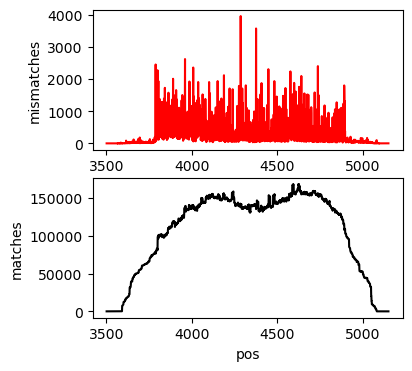

In [2]:
# plot sequencing results
df = pd.read_table("../01-data/LBspec-mut1_S19_L001_mapping.sorted.bam.var.txt")
df = df.query("pos>3500 and pos<5500")

fig, ax = plt.subplots(2,1,figsize=(4,4))
sns.lineplot(data=df,x="pos",y="mismatches",color="red",ax=ax[0])
sns.lineplot(data=df,x="pos",y="matches",color="black",ax=ax[1])

In [3]:
def plot_heatmap(df,col,plot_ax,title,min_cbar,max_cbar,grouped):
    """
    plots a heatmap for a given DataFrame column
    """
    g = sns.heatmap(data=[df[col]],
                    xticklabels=True,
                    yticklabels=False,
                    cmap=MAGENTA_CMAP,
                    ax=plot_ax,
                    vmin=min_cbar,
                    vmax=max_cbar,
                    cbar=None,
                    alpha=1.0)
    for i in range(df.shape[0]):
        rect = Rectangle((i, 0), 1, 1, fill=False, edgecolor="black", lw=0.5)
        g.add_patch(rect)
    if not grouped:
        g.set_xticklabels(labels=list(title),rotation=0)
    else:
        g.set_xticklabels(labels=[],rotation=0)
    g.tick_params(axis="both",which="both",length=0)
    g.set_ylabel(g.get_ylabel(), fontdict={"weight": "bold","size":12})

def plot_residues(df, col, num_cols, seq, id, grouped=False, group_size=3, out_dir="."):
    """
    plots residue heatmaps, grouped if necessary
    """
    if grouped:
        df["number"] = df.index // (1 * group_size)
        df = df.groupby(["number"]).max().reset_index()
        figsize = (12,ceil(len(df)/num_cols))
    else:
        figsize = (10, ceil(len(df)/num_cols)*0.5)

    fig = plt.figure(figsize=figsize)
    gs = GridSpec(ceil(len(df)/num_cols),2,width_ratios=[80, 2],hspace=1,wspace=0.025)

    min_cbar, max_cbar = df[col].min(), df[col].max()
    range_list = list(range(0, len(df), num_cols)) + [len(df)]
    range_tuples = [(range_list[i], range_list[i + 1]) for i in range(len(range_list) - 1)]
    for i,(min_res,max_res) in enumerate(range_tuples):
        subseq = seq[min_res:max_res]
        plot_heatmap(df.iloc[min_res:max_res,:],
                     col=col,
                     plot_ax=fig.add_subplot(gs[i,0]),
                     title=subseq,
                     min_cbar=min_cbar,
                     max_cbar=max_cbar,
                     grouped=grouped)
    cbar = ColorbarBase(fig.add_subplot(gs[:,1]), cmap=MAGENTA_CMAP,orientation="vertical",norm=Normalize(min_cbar, max_cbar))
    cbar.outline.set_linewidth(0.5)

    if SAVE_FIGURES:
        fig.savefig(f"{out_dir}/{id}_cols{num_cols}_grouped{grouped}.png",transparent=False,bbox_inches="tight",dpi=400,facecolor="white")

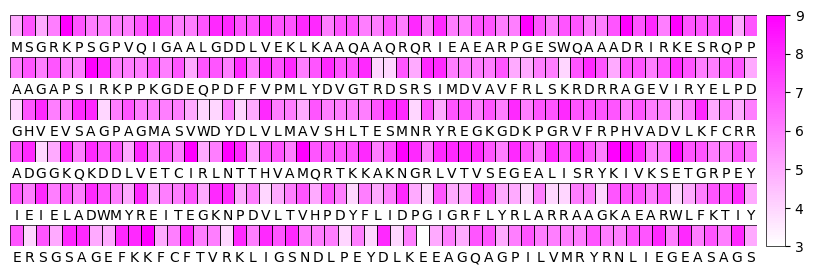

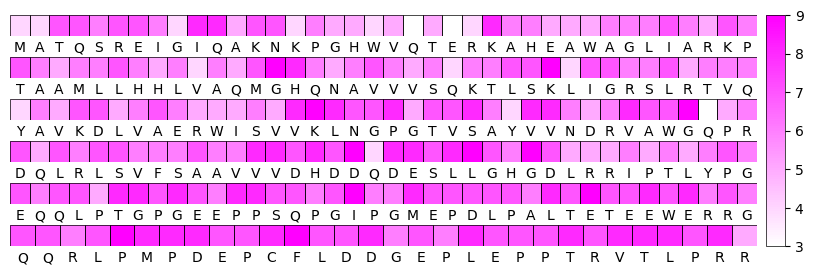

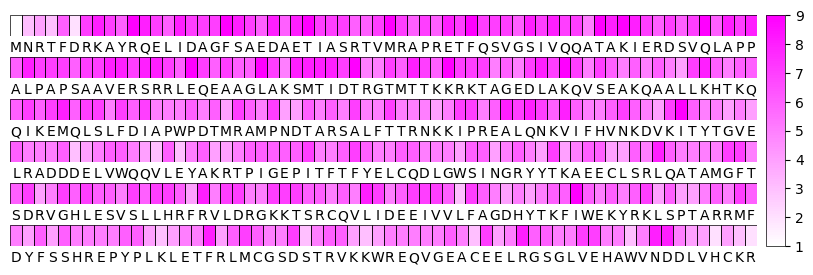

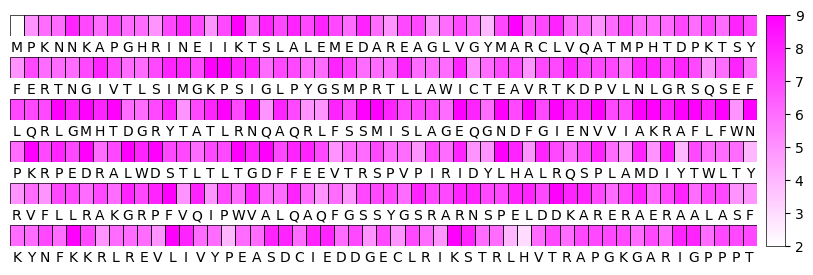

In [4]:
# import SNP data calculated by Mitch
snp_df = None
for snp_file in glob("../01-data/*_SNP_Counts_Final.csv"):
    handle = snp_file.split("/")[-1].split("_")[0]
    tmp_df = pd.read_csv(snp_file)
    tmp_df = (tmp_df
              .groupby("AApos")["thresh_nuc"]
              .count()
              .reset_index()
              .rename(columns={"thresh_nuc":handle})
              .set_index("AApos")
              )
    snp_df = pd.concat([snp_df,tmp_df],axis=1)

# melt SNP data
melted_df = (snp_df
 .reset_index()
 .melt(id_vars="AApos",
       var_name="origin",
       value_vars=["BBR1","pSa","RK2","pVS1"],
       value_name="res_count"))

# plot melted SNP data (excludes stop codon)
plot_configs = [
    {"origin": "pVS1", "exclude": 358, "num_cols": 60, "seq": PVS1,"id": "pVS1"},
    {"origin": "BBR1", "exclude": 221, "num_cols": 38, "seq": BBR1,"id": "BBR1"},
    {"origin": "RK2", "exclude": 383, "num_cols": 64, "seq": RK2, "id": "RK2"},
    {"origin": "pSa", "exclude": 324, "num_cols": 54, "seq": PSA, "id": "pSa"}
]

for config in plot_configs:
    df_filtered = (melted_df
                   .query(f'origin == "{config["origin"]}" and AApos != {config["exclude"]}')
                   .dropna())
    
    plot_residues(df=df_filtered,
                  col="res_count",
                  num_cols=config["num_cols"],
                  seq=config["seq"],
                  id=config["id"])